In [35]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [36]:
transaction_train = pd.read_csv('train_transaction.csv')

/Users/chowshengyang/Desktop/NUS/NUS/Y3S1/BT4222/Group_Project/datasets/ieee-fraud-detection


In [37]:
def header(text):
    print(f"\033[94m\033[1m", text, f"\033[0m")

def num_nulls(df, perc=False) -> dict:
    nulls_dict = {}
    for col in df.columns:
        num_nulls = int(df[col].isnull().sum())
        if perc == True:
            nulls_dict[col] = (num_nulls / len(df[col])) * 100
        else:
            nulls_dict[col] = num_nulls
    return nulls_dict

def split_features(df, split_by):
    others = df.drop(columns=split_by)
    split = df.loc[:, split_by]
    return split, others

def extract_df(df):
    num_cols = list(df.select_dtypes('number').columns)
    cat_cols = [j for j in df.columns if j not in num_cols]
    numeric, cat = split_features(df, split_by=num_cols)
    return numeric, cat

def preprocess_data(
        df,
        target:str,
        remove_nulls_threshold:int,
        remove_nulls=False,
        interpolate=False,
        standardise=False,
        ) -> pd.DataFrame:
    
    # split independent & target:
    y, Xs = split_features(df, target)
    
    # number of independent features:
    k = len(Xs.columns)
    
    # work on Y feature:
    if y.isnull().sum() > 0:
        y.interpolate(limit_area='inside')
        print('Target Feature has missing values being interpolated.')
    elif y.unique().sum() != 1:
        print('Target Feature is not binary.')
    else:
        y = pd.to_numeric(y)

    # remove any columns with constant values
    Xs = Xs[Xs.columns[Xs.nunique() > 1]]
    header('Number of Columns with constant values dropped:') 
    print(f'{k - len(Xs.columns)}')

    # replace any non-NaN missing values with NaN
    Xs = Xs.replace([float('inf'), float('-inf'), None, 'NULL', 'Null', 'null'], float('nan'))
    
    if interpolate is True:
        Xs = Xs.interpolate(limit_area='inside')
        header(f'Features with missing values interpolated.')
        
    # remove any columns that have > x null values
    if remove_nulls is True:
        null_dict = num_nulls(Xs, perc=True)
        nullcols = [i for i in null_dict.keys() if null_dict[i] >= remove_nulls_threshold]
        Xs = Xs.loc[:, [c for c in Xs.columns if c not in nullcols]]
        header('Number of Columns with > 50% NaN droped:')
        print(f'{len(nullcols)}')

    # standardise numerical columns
    if standardise is True:
        z = StandardScaler()
        num, cat = extract_df(Xs)
        for j in num.columns:
            if j == 'TransactionID':
                continue
            else:
                Xs[j] = z.fit_transform(Xs[j].to_numpy().reshape(-1, 1))

    # encode any bool columns and any strings labelled T/F to 1/0
    Xs[Xs.columns[Xs.dtypes == 'bool']] += 0
    for x in Xs.columns:
        if ('T' in set(Xs[x])) or ('F' in set(Xs[x])):
            Xs[x] = Xs[x].replace('T', 1).replace('F', 0)

    # rejoin Xs and Y features
    newdf = pd.concat([Xs, y], axis=1)

    return newdf

# TRANSACTION DATA

In [38]:
header('Original Training Data:')
display(transaction_train)

# preprocess transaction_train:
cleaned_transaction_train = preprocess_data(df=transaction_train,
                                            target='isFraud',
                                            remove_nulls=True,
                                            remove_nulls_threshold=50,
                                            interpolate=False,
                                            standardise=True     
                                    )

header('Preprocessed Training Data:')
display(cleaned_transaction_train)

# correlation matrix:
header('Correlation Matrix for pairwise r > 0.5:')
numerics, categoricals = extract_df(cleaned_transaction_train)
pearsonr = numerics.corr()
display(pearsonr[pearsonr > 0.5])

 Original Training Data: 


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 Number of Columns with constant values dropped: 
0
 Number of Columns with > 50% NaN droped: 
174
 Preprocessed Training Data: 


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V313,V314,V315,V316,V317,V318,V319,V320,V321,isFraud
0,2987000,-1.577987,-0.278167,W,0.821695,NaN,-0.281828,discover,-1.388767,credit,...,-0.222636,-0.249507,-0.229407,-0.048378,-0.032815,-0.058050,-0.055288,-0.088856,-0.074143,0
1,2987001,-1.577986,-0.443327,W,-1.457558,0.262651,-0.281828,mastercard,-2.358595,credit,...,-0.222636,-0.249507,-0.229407,-0.048378,-0.062212,-0.058050,-0.055288,-0.088856,-0.074143,0
2,2987002,-1.577972,-0.317889,W,-1.068263,0.807668,-0.281828,visa,-0.806870,debit,...,-0.222636,-0.249507,-0.229407,-0.048378,-0.062212,-0.058050,-0.055288,-0.088856,-0.074143,0
3,2987003,-1.577965,-0.355521,W,1.679858,1.295649,-0.281828,mastercard,-1.994910,debit,...,-0.222636,-0.249507,-0.229407,-0.026351,0.290548,0.224765,-0.055288,-0.088856,-0.074143,0
4,2987004,-1.577964,-0.355521,H,-1.102133,0.959766,-0.281828,mastercard,-2.358595,credit,...,-0.222636,-0.249507,-0.229407,-0.048378,-0.062212,-0.058050,-0.055288,-0.088856,-0.074143,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,1.827666,-0.359702,W,-0.683253,NaN,-0.281828,visa,0.647872,debit,...,0.277349,0.026672,0.180937,-0.048378,-0.062212,-0.058050,-0.055288,-0.088856,-0.074143,0
590536,3577536,1.827666,-0.399424,W,0.111252,-0.871746,-0.281828,mastercard,0.599381,debit,...,-0.222636,-0.249507,-0.229407,-0.048378,-0.062212,-0.058050,-0.055288,-0.088856,-0.074143,0
590537,3577537,1.827673,-0.435174,W,0.436277,1.473097,-0.281828,mastercard,0.599381,debit,...,-0.222636,-0.249507,-0.229407,-0.048378,-0.062212,-0.058050,-0.055288,-0.088856,-0.074143,0
590538,3577538,1.827675,-0.075376,W,-0.422906,0.750632,-0.281828,mastercard,0.599381,debit,...,3.088004,3.606640,2.487679,-0.048378,0.499089,-0.058050,-0.055288,-0.088856,-0.074143,0


 Correlation Matrix for pairwise r > 0.5 


,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,...,V313,V314,V315,V316,V317,V318,V319,V320,V321,isFraud
TransactionID,1.00000,0.99828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TransactionDT,0.99828,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TransactionAmt,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
card1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
card2,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.938424,0.970185,1.000000,NaN,0.619716,NaN,NaN
V319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.788216,0.921923,NaN
V320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.551337,0.592800,0.619716,0.788216,1.000000,0.937500,NaN
V321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.921923,0.937500,1.000000,NaN


 Datatypes of each Feature: 
{dtype('int64'), dtype('float64'), dtype('O')}
 Proportion of Fraud Class: 


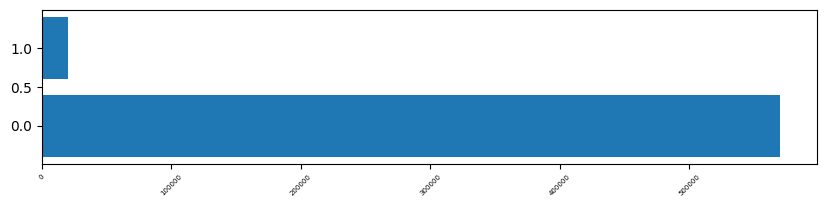

 Visualise _TransactionAmt: 


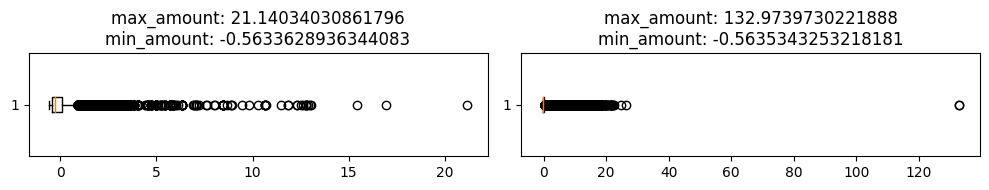

In [60]:

fs=(10, 2)

# datatypes of each feature:
header("Datatypes of each Feature:")
print(set(cleaned_transaction_train.dtypes))

# EDA on _isFraud:
header('Proportion of Fraud Class:')
plt.figure(figsize=fs)
isfraud = cleaned_transaction_train.isFraud.value_counts().to_dict()
plt.barh(list(isfraud.keys()), list(isfraud.values()))
plt.xticks(rotation=45, fontsize=5)
plt.show()

# EDA on _TransactionAmt:
header('Visualise _TransactionAmt:')
fraud_cond, no_fraud_cond = cleaned_transaction_train['isFraud'] == 1, cleaned_transaction_train['isFraud'] == 0
T_Amt_Fraud = cleaned_transaction_train[fraud_cond]['TransactionAmt'].to_numpy()
T_Amt_NoFraud = cleaned_transaction_train[no_fraud_cond]['TransactionAmt'].to_numpy()

fig, axs = plt.subplots(1, 2, figsize=fs, tight_layout=True)

bp1 = axs[0].boxplot(T_Amt_Fraud, vert=False)
axs[0].set_title(f'max_amount: {max(T_Amt_Fraud)}\nmin_amount: {min(T_Amt_Fraud)}')
bp2 = axs[1].boxplot(T_Amt_NoFraud, vert=False)
axs[1].set_title(f'max_amount: {max(T_Amt_NoFraud)}\nmin_amount: {min(T_Amt_NoFraud)}')

plt.show()


# IDENTITY DATA

In [ ]:
identity_train = pd.read_csv('train_identity.csv')

display(identity_train)

cleaned_identity_train = preprocess_data(df=identity_train,
                                         target='TransactionID',
                                         remove_nulls=True,
                                         remove_nulls_threshold=50,
                                         interpolate=False,
                                         standardise=True)

display(cleaned_identity_train)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144228,3577521,-15.0,145955.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 66.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,F3111 Build/33.3.A.1.97
144229,3577526,-5.0,172059.0,NaN,NaN,1.0,-5.0,NaN,NaN,NaN,...,chrome 55.0 for android,32.0,855x480,match_status:2,T,F,T,F,mobile,A574BL Build/NMF26F
144230,3577529,-20.0,632381.0,NaN,NaN,-1.0,-36.0,NaN,NaN,NaN,...,chrome 65.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,Moto E (4) Plus Build/NMA26.42-152
144231,3577531,-5.0,55528.0,0.0,0.0,0.0,-7.0,NaN,NaN,0.0,...,chrome 66.0,24.0,2560x1600,match_status:2,T,F,T,F,desktop,MacOS


Target Feature is not binary.
 Number of Columns with constant values dropped: 
0
 Number of Columns with > 50% NaN droped: 
12


,id_01,id_02,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionID
0,0.708850,-0.650979,NaN,NaN,NaN,NaN,0.225856,NotFound,NaN,-1.446107,...,1.46928,2220x1080,match_status:2,1.0,0.0,1.0,1.0,mobile,SAMSUNG SM-G892A Build/NRD90M,2987004
1,0.360366,-0.474607,-0.307740,0.103008,NaN,NaN,0.225856,NotFound,0.080420,0.475022,...,1.46928,1334x750,match_status:1,1.0,0.0,0.0,1.0,mobile,iOS Device,2987008
2,0.360366,0.105946,-0.307740,0.406203,-0.092519,0.107952,0.225856,NotFound,0.335201,NaN,...,NaN,NaN,NaN,0.0,0.0,1.0,1.0,desktop,Windows,2987010
3,0.360366,0.295115,-0.307740,0.042369,NaN,NaN,0.225856,NotFound,0.335201,NaN,...,NaN,NaN,NaN,0.0,0.0,1.0,1.0,desktop,NaN,2987011
4,0.708850,-1.047637,-0.117258,0.406203,-0.092519,0.107952,0.225856,NotFound,NaN,0.475022,...,-0.67120,1280x800,match_status:2,1.0,0.0,1.0,1.0,desktop,MacOS,2987016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144228,-0.336600,-0.180153,-0.307740,0.406203,-0.092519,0.107952,0.225856,NotFound,-1.787975,NaN,...,NaN,NaN,NaN,0.0,0.0,1.0,0.0,mobile,F3111 Build/33.3.A.1.97,3577521
144229,0.360366,-0.016646,-0.117258,0.103008,NaN,NaN,0.225856,NotFound,-1.787975,0.475022,...,1.46928,855x480,match_status:2,1.0,0.0,1.0,0.0,mobile,A574BL Build/NMF26F,3577526
144230,-0.685083,2.866651,-0.498222,-1.776800,NaN,NaN,0.225856,NotFound,-1.787975,NaN,...,NaN,NaN,NaN,0.0,0.0,1.0,0.0,mobile,Moto E (4) Plus Build/NMA26.42-152,3577529
144231,0.360366,-0.746556,-0.307740,-0.018270,-0.092519,0.107952,0.225856,NotFound,-1.787975,0.475022,...,-0.67120,2560x1600,match_status:2,1.0,0.0,1.0,0.0,desktop,MacOS,3577531
